In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
import tensorflow_gan as tfgan
from tensorflow.keras.applications import VGG16
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import polynomial_kernel

2024-08-23 07:13:59.739316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.__version__

'2.13.0'

In [4]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [5]:
readDatasetObject = ReadDataset('/tf/train',
                               ['NORMAL', 'PNEUMONIA'],(64, 64)
                               )
images, labels = readDatasetObject.readImages()

In [6]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


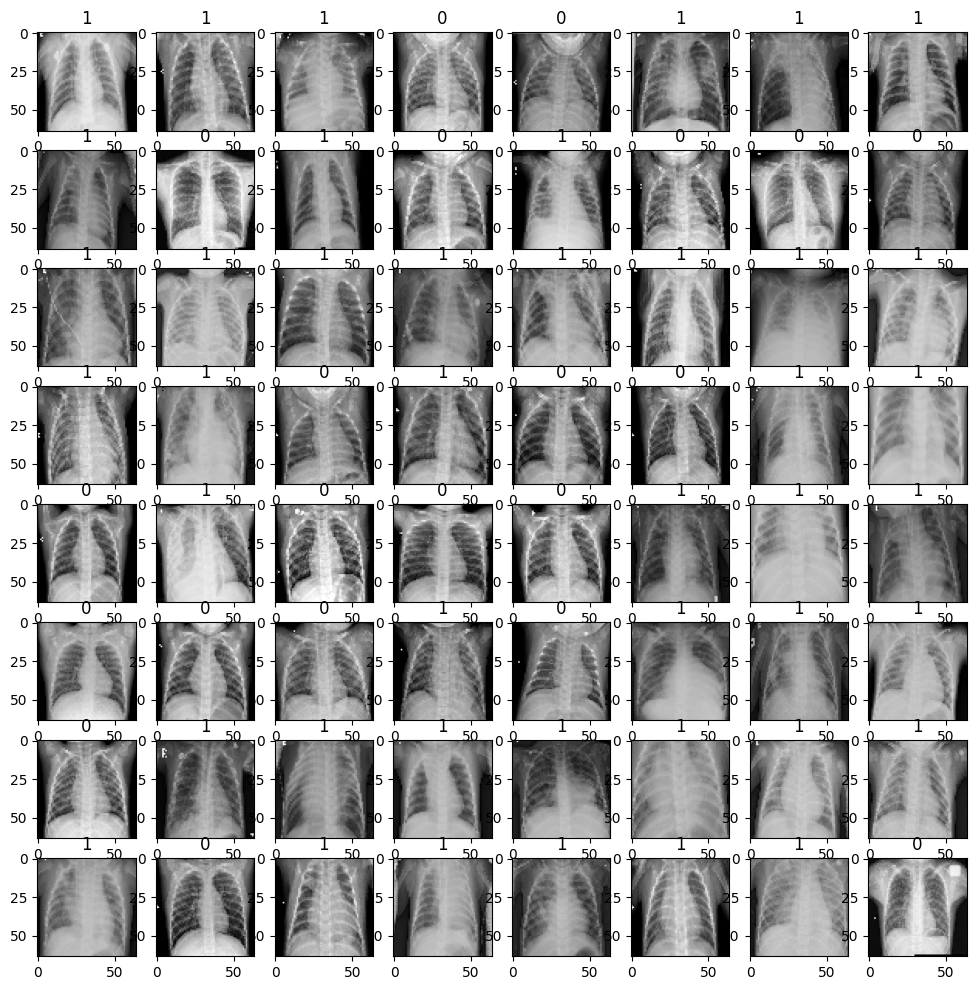

In [7]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [8]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size

    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap='gray')
            plt.title(ys[i])
        plt.show()

    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024)(x)
        x = layers.Dense(8*8*filters[0], kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = layers.LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding, strides=strides)(x)
        x = Conv2DTranspose(3, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels], outputs=x, name='generator')

    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding, strides=strides,
                      kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1)(x)
        labelsOutput = Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs, outputs=[outputs, labelsOutput], name='discriminator')

    def build(self):
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2,))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss=['mse', 'binary_crossentropy'],
                 optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta, weight_decay=self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs=[generatorInput, labelsInput], outputs=D(G([generatorInput, labelsInput])))
        GAN.compile(loss=['mse', 'binary_crossentropy'],
                   optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta*0.5, weight_decay=self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN

    def save_model_weights(self, G, D, GAN, epoch):
        G.save_weights(f'generator_weights_epoch_{epoch}.h5')
        D.save_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.save_weights(f'gan_weights_epoch_{epoch}.h5')

    def load_model_weights(self, G, D, GAN, epoch):
        G.load_weights(f'generator_weights_epoch_{epoch}.h5')
        D.load_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.load_weights(f'gan_weights_epoch_{epoch}.h5')

    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size=(self.batch_size,))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape=(self.batch_size,))
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)), num_classes=2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose=0))
            fakeTag = tf.zeros(shape=(self.batch_size,))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag, dlossLabels, glossTag, glossLabels))
                self.samples(G, noize, fakeLabels)
                # Save model weights
                self.save_model_weights(G, D, GAN, epoch)

In [9]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 32000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [10]:
acgan.data(images, labels)

In [11]:
G, D, GAN = acgan.build()

2024-08-23 07:14:54.274587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12248 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           2432      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu[0][0]']         
                                                                                      

In [12]:
#tf.keras.utils.plot_model(GAN, show_shapes = True)

In [13]:
#tf.keras.utils.plot_model(G, show_shapes = True)

In [14]:
#tf.keras.utils.plot_model(D, show_shapes = True)

In [15]:
last_epoch = 30000
acgan.load_model_weights(G, D, GAN, last_epoch)

2024-08-23 07:14:56.540157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-08-23 07:14:58.183576: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa25debc3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-23 07:14:58.183628: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-23 07:14:58.190277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-23 07:14:58.349000: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0
discriminator loss: [tag: 0.20063568651676178, labels: 0.0004998525255359709], generator loss: [tag: 0.5192448496818542, labels: 0.002171935746446252]
1/1 [==============================] - 0s 27ms/step


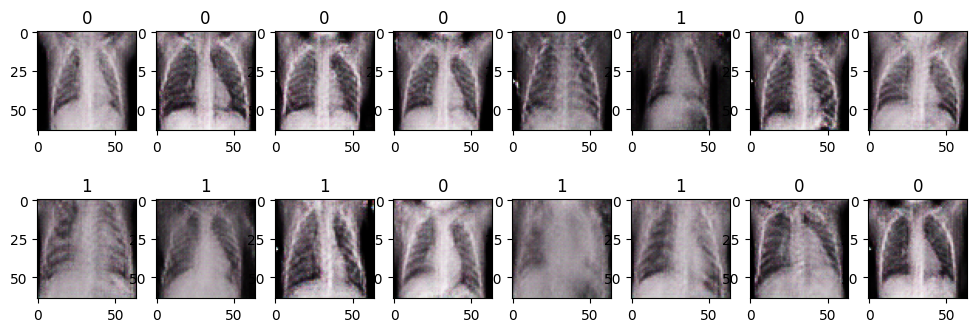

Epoch: 5000
discriminator loss: [tag: 0.1927156150341034, labels: 0.0005706156371161342], generator loss: [tag: 0.6420215964317322, labels: 0.00046305436990223825]
1/1 [==============================] - 0s 22ms/step


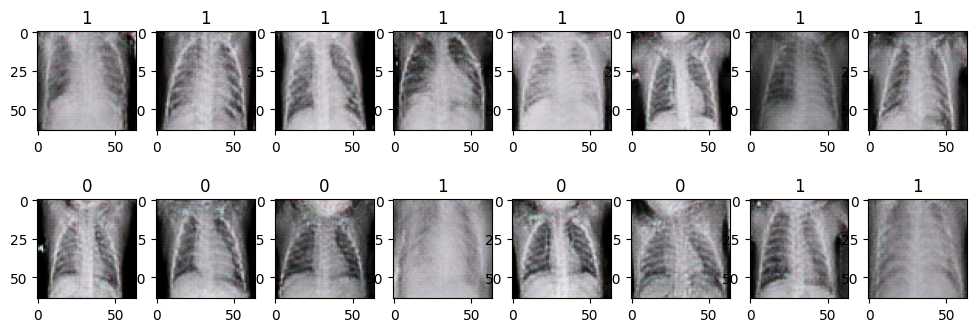

Epoch: 10000
discriminator loss: [tag: 0.14782528579235077, labels: 0.008265036158263683], generator loss: [tag: 0.533038318157196, labels: 4.522620656643994e-05]
1/1 [==============================] - 0s 22ms/step


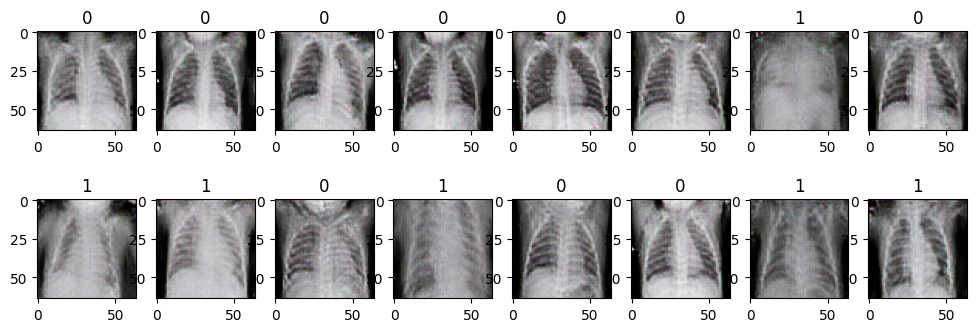

Epoch: 15000
discriminator loss: [tag: 0.12092487514019012, labels: 0.0010272740619257092], generator loss: [tag: 0.5670678019523621, labels: 0.006953388452529907]
1/1 [==============================] - 0s 22ms/step


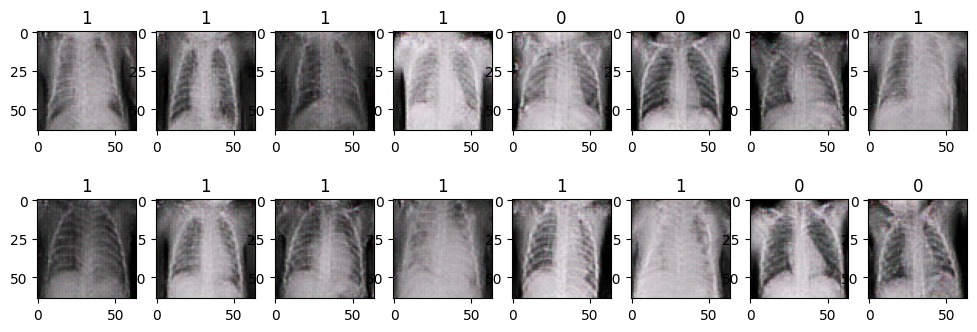

Epoch: 20000
discriminator loss: [tag: 0.08494873344898224, labels: 0.007144861854612827], generator loss: [tag: 0.650733232498169, labels: 0.00013109936844557524]
1/1 [==============================] - 0s 20ms/step


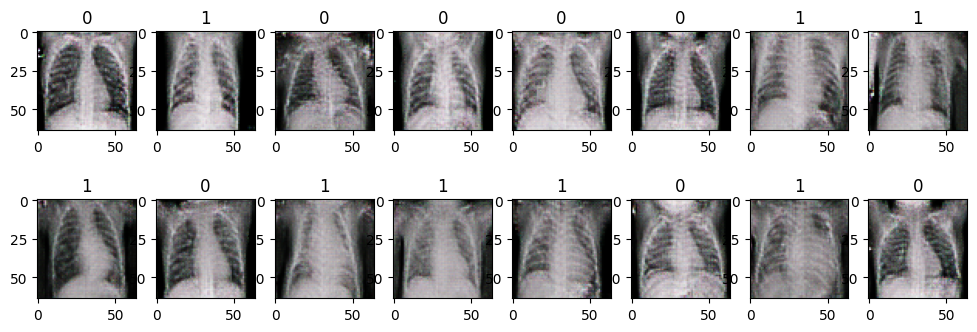

Epoch: 25000
discriminator loss: [tag: 0.08686229586601257, labels: 0.010845436714589596], generator loss: [tag: 0.6754580736160278, labels: 0.002637311350554228]
1/1 [==============================] - 0s 20ms/step


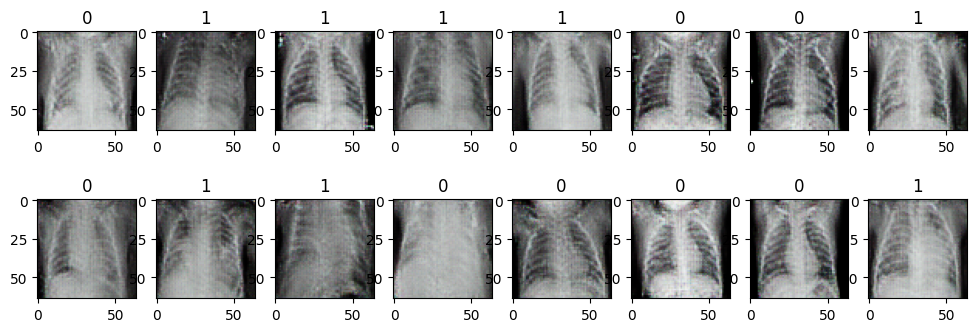

Epoch: 30000
discriminator loss: [tag: 0.057699643075466156, labels: 0.004101705737411976], generator loss: [tag: 0.7746052742004395, labels: 8.286968659376726e-05]
1/1 [==============================] - 0s 21ms/step


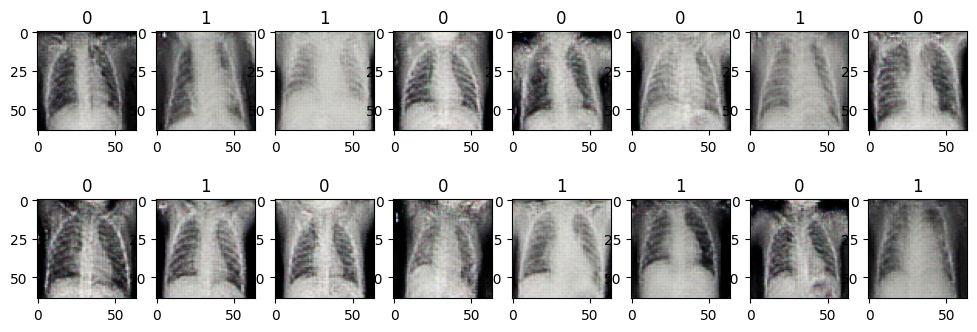

In [16]:
acgan.trainAlgorithm(G, D, GAN)

In [17]:
G.save('/tf/Model1')

INFO:tensorflow:Assets written to: /tf/Model1/assets


INFO:tensorflow:Assets written to: /tf/Model1/assets


In [18]:
#G = tf.keras.models.load_model('/content/drive/MyDrive/MyFolder')

In [19]:
def calculate_fid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)

    # Calculate the mean and covariance of the activations
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate FID score
    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    
    # Numerical error can occur in sqrtm, so check if the result is complex
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid


In [20]:
def calculate_kid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)
    
    # Compute polynomial kernels
    kernel_real = polynomial_kernel(act_real)
    kernel_gen = polynomial_kernel(act_gen)
    kernel_cross = polynomial_kernel(act_real, act_gen)
    
    m = len(real_images)
    n = len(generated_images)
    
    # Calculate KID score
    kid = (np.sum(kernel_real) / (m * m)) + (np.sum(kernel_gen) / (n * n)) - (2 * np.sum(kernel_cross) / (m * n))
    return kid


In [21]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [22]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [23]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([15022, 14978]))

In [24]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 9s 9ms/step


(30000, 64, 64, 3)

In [25]:
# Calculate FID and KID scores
fid_score = calculate_fid(images, imagesGeneration)
kid_score = calculate_kid(images, imagesGeneration)

print(f'FID Score: {fid_score}')
print(f'KID Score: {kid_score}')


938/938 [==============================] - 5s 5ms/step
FID Score: 1.304083391265219
KID Score: 0.007488472054524742


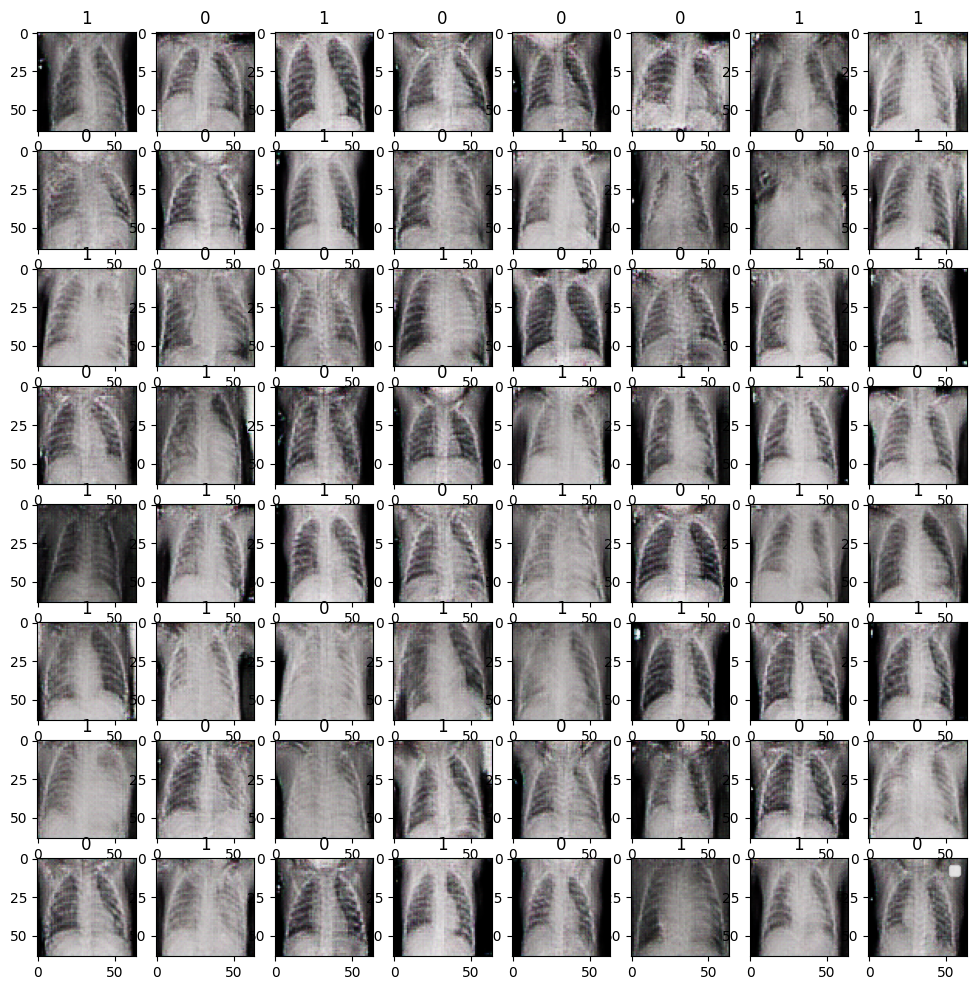

In [26]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In [27]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [28]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 20s 35ms/step - loss: 0.3384 - val_loss: 0.5808
Epoch 2/60
375/375 [==============================] - 12s 31ms/step - loss: 0.1239 - val_loss: 0.1347
Epoch 3/60
375/375 [==============================] - 12s 32ms/step - loss: 0.0922 - val_loss: 0.0542
Epoch 4/60
375/375 [==============================] - 12s 32ms/step - loss: 0.0782 - val_loss: 0.0474
Epoch 5/60
375/375 [==============================] - 12s 32ms/step - loss: 0.0694 - val_loss: 0.0359
Epoch 6/60
375/375 [==============================] - 12s 32ms/step - loss: 0.0602 - val_loss: 0.0336
Epoch 7/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0561 - val_loss: 0.0805
Epoch 8/60
375/375 [==============================] - 12s 32ms/step - loss: 0.0495 - val_loss: 0.0303
Epoch 9/60
375/375 [==============================] - 12s 32ms/step - loss: 0.0444 - val_loss: 0.0351
Epoch 10/60
375/375 [==============================] - 12s 31ms/step - loss: 0.041

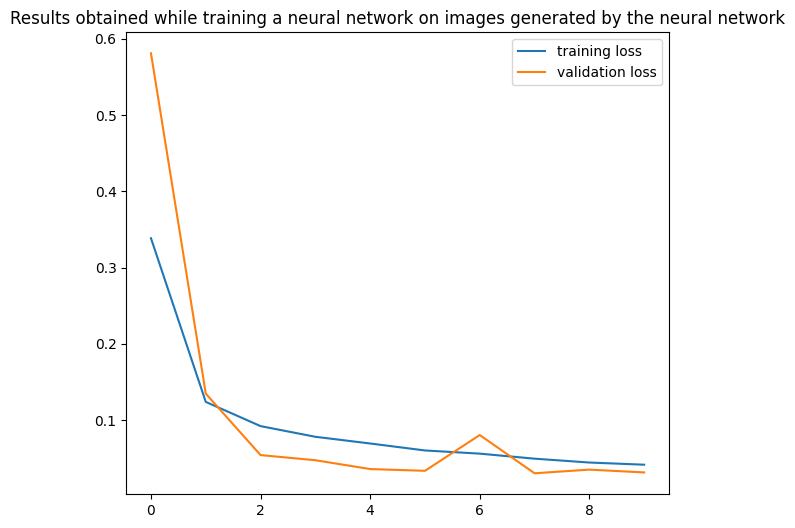

In [29]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [30]:
m.evaluate(images, labels)

163/163 [==============================] - 1s 9ms/step - loss: 0.2459


0.24585166573524475

In [31]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 1s 6ms/step


TensorShape([5216])

In [32]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [33]:
accuracy_score(y_pred, labels)*100

90.33742331288343

In [34]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1807
           1       0.87      0.99      0.93      3409

    accuracy                           0.90      5216
   macro avg       0.93      0.86      0.89      5216
weighted avg       0.91      0.90      0.90      5216



In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1322,  485],
       [  19, 3390]])

In [36]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL       1322        485
PNEUMONIA      19       3390

In [37]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 93.08072487644151, recall_score: 99.44265180404811, precision_score: 87.48387096774194


<Axes: >

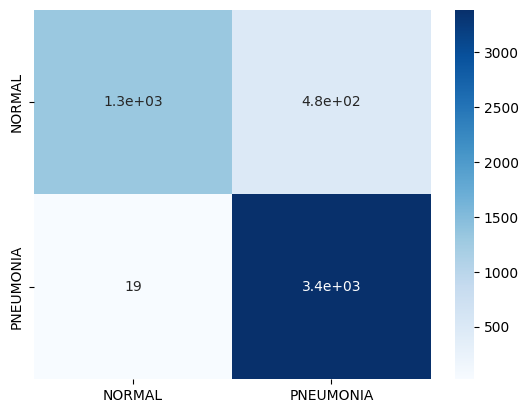

In [38]:
sns.heatmap(cmObject, annot = True, cmap="Blues")